INITIAL DATA LOADING
Loaded edge list rows: 217331
Columns: ['source', 'source_desc', 'source_id', 'target', 'target_desc', 'target_id', 'weight']
Initial data shape: (217331, 7)

First 5 rows:
    source                       source_desc source_id  \
0  GeneSym  rsID_Chromosome_Position_Context    GeneID   
1    ZNF18     rs10852800_17_11884516_intron      7566   
2     STK4       rs927000_20_43598705_intron      6789   
3  AFG3L1P      rs4408545_16_90044028_intron       172   
4   ZNF276    rs6500437_16_89789898_missense     92822   

                        target   target_desc target_id    weight  
0                      Disease          DOID       NaN    weight  
1  integumentary system cancer  DOID:0060122      -666  1.000000  
2  integumentary system cancer  DOID:0060122      -666  1.000000  
3  integumentary system cancer  DOID:0060122      -666  1.000000  
4  integumentary system cancer  DOID:0060122      -666  1.000000  

COMPREHENSIVE DATA PREPROCESSING

--- MISSING VALUE AN

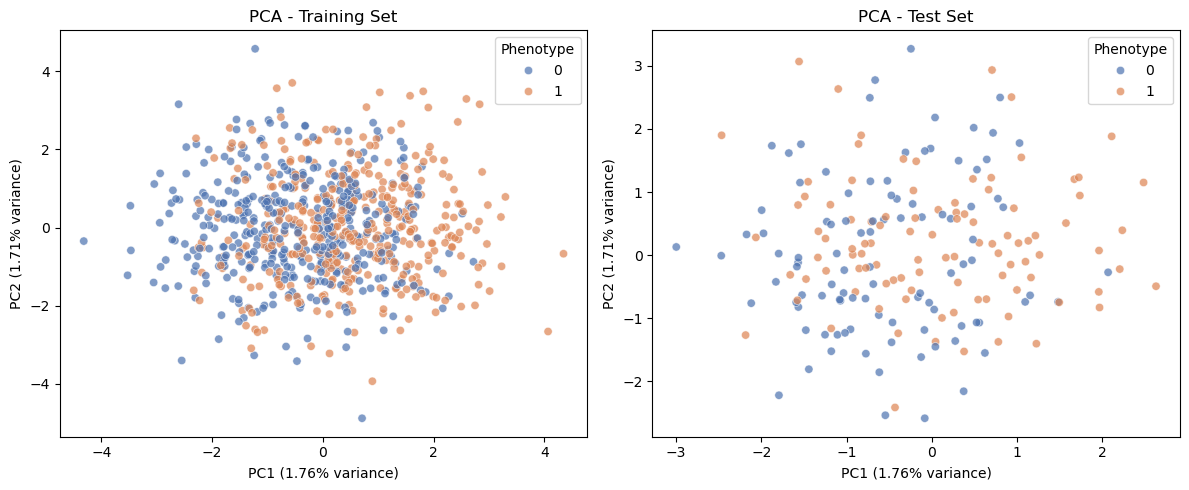


MODEL TRAINING AND EVALUATION

--- LOGISTIC REGRESSION (PCA Features) ---
Using 2 principal components
Logistic Regression (PCs) classification report:
              precision    recall  f1-score   support

           0       0.60      0.72      0.65       100
           1       0.65      0.51      0.57       100

    accuracy                           0.61       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200

ROC-AUC (LR): 0.6594

--- LOGISTIC REGRESSION (Original Features) ---
Logistic Regression (Original) classification report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       100
           1       0.92      0.97      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200

ROC-AUC (LR Original): 0.9891

--- XGBOOST CLASSIFICATION ---
XGBoost

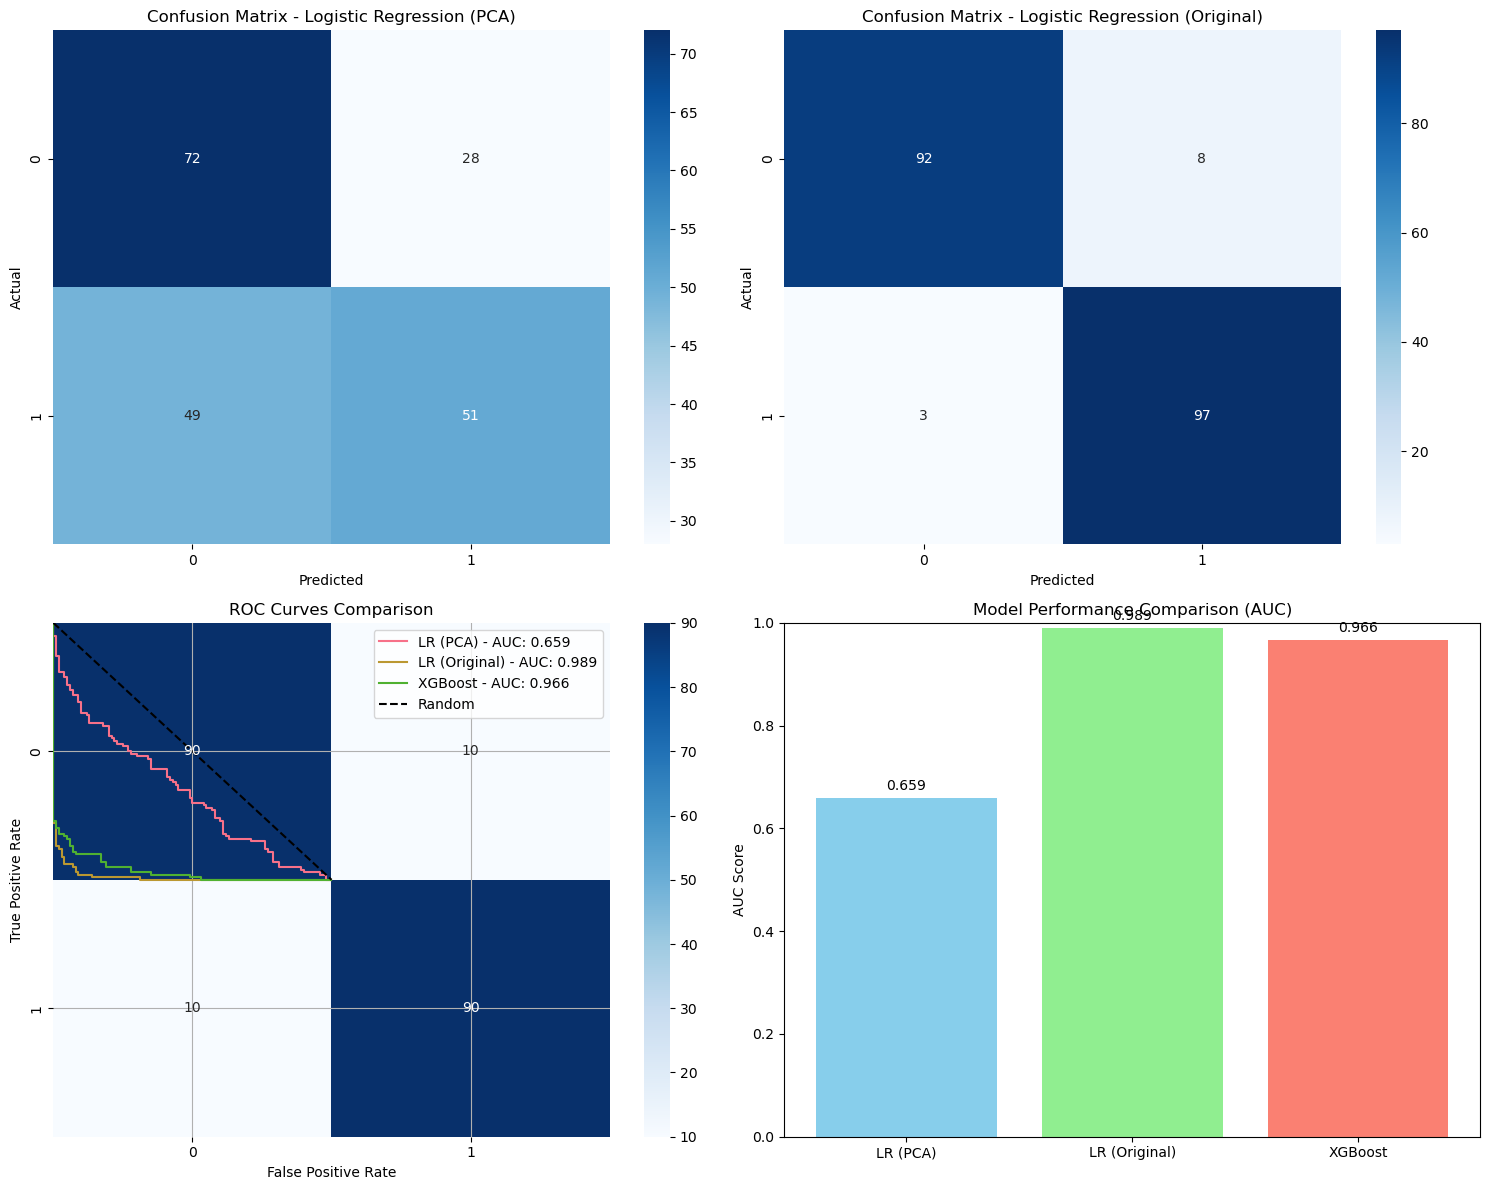


--- FEATURE IMPORTANCE ANALYSIS ---
Top 15 XGBoost features by gain:
       feature      gain
14  rs12902711  5.031097
79  rs10253192  2.656105
13   rs4075020  2.611000
60   rs7201926  2.234612
89   rs4856554  2.211529
63   rs6903616  2.199865
31   rs2030958  2.062042
8    rs6791490  1.553627
1     rs164741  1.525823
52  rs12431702  1.439588
3   rs10001138  1.394795
23   rs7598777  1.268368
84   rs1732887  1.252297
45   rs2078478  1.251462
44   rs4785755  1.246460


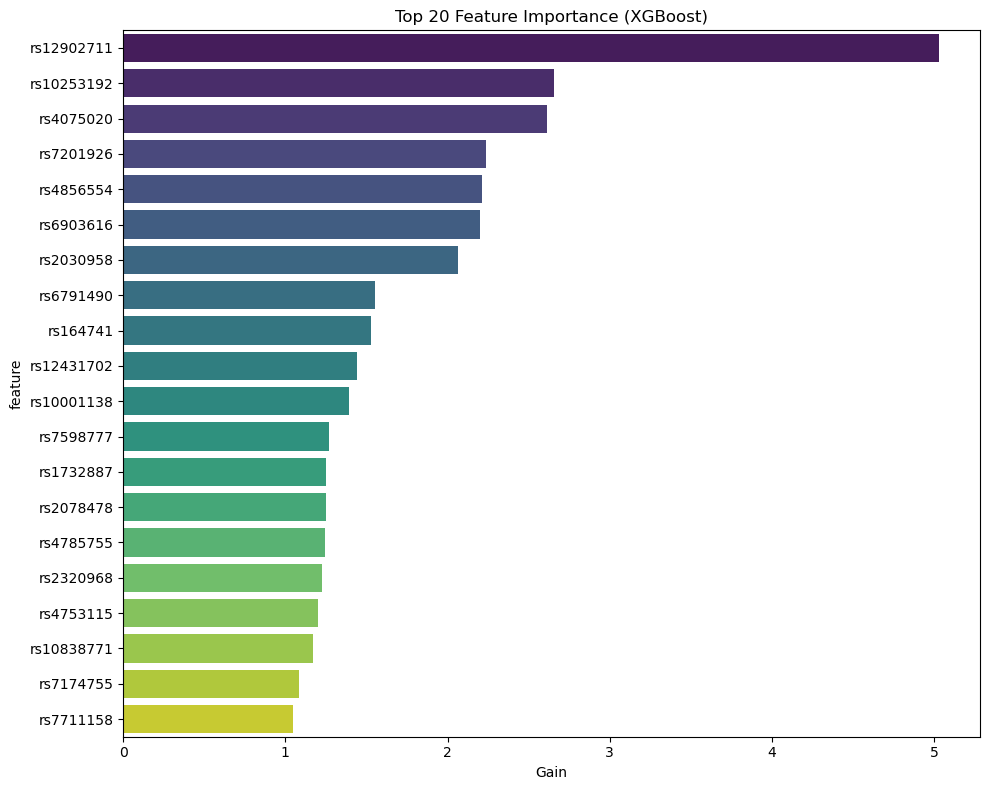


--- SHAP EXPLAINABILITY ---


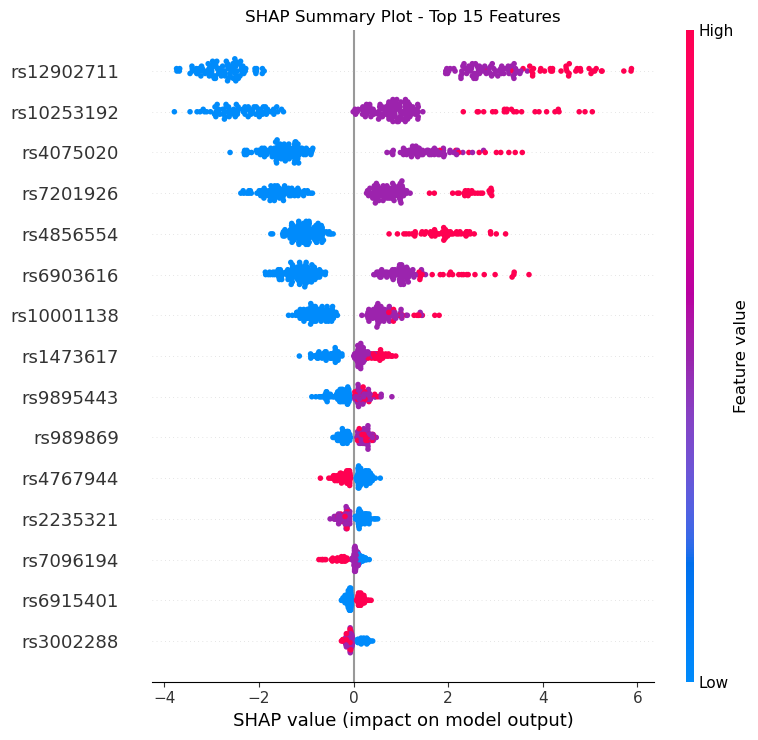

SHAP values shape: (200, 100)
Mean absolute SHAP value: 0.1553
Max absolute SHAP value: 5.8770

FINAL PREPROCESSING AND MODELING SUMMARY

DATA PREPROCESSING SUMMARY:
- Original dataset size: (217331, 7)
- After preprocessing: (217331, 11)
- Missing values handled: -6
- Duplicates removed: 0
- Features selected: 100
- Training samples: 800
- Test samples: 200

MODEL PERFORMANCE SUMMARY:
- Logistic Regression (PCA): 0.6594
- Logistic Regression (Original): 0.9891
- XGBoost: 0.9662

Best performing model: Logistic Regression (Original) (AUC: 0.9891)

Preprocessing pipeline completed successfully!


In [1]:
# Requirements: pandas, numpy, scikit-learn, xgboost, shap, matplotlib, seaborn, scipy
# pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn scipy

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Core ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer, KNNImputer

# Data processing libraries
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# Set style
plt.style.use('default')
sns.set_palette("husl")

# --- 1. Load the Harmonizome edge list CSV ---
# Replace filename with your downloaded file path
edgefile = "gene_attribute_edges.txt"
df = pd.read_csv(edgefile, sep='\t', dtype=str)  # using dtype=str to be robust

print("="*60)
print("INITIAL DATA LOADING")
print("="*60)
print(f"Loaded edge list rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Initial data shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# --- 2. COMPREHENSIVE DATA PREPROCESSING ---
print("\n" + "="*60)
print("COMPREHENSIVE DATA PREPROCESSING")
print("="*60)

# 2.1 Missing Value Analysis and Handling
print("\n--- MISSING VALUE ANALYSIS ---")
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentages.values
}).sort_values('Missing_Count', ascending=False)

print("Missing value summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Handle missing values
print(f"\nTotal missing values before handling: {df.isnull().sum().sum()}")
df_processed = df.copy()

# For string columns, fill with 'unknown'
string_cols = df_processed.select_dtypes(include=['object']).columns
for col in string_cols:
    df_processed[col] = df_processed[col].fillna('unknown')

# For numeric columns, we'll handle them later after conversion
print(f"Missing values after string handling: {df_processed.isnull().sum().sum()}")

# 2.2 Duplicate Detection and Removal
print("\n--- DUPLICATE ANALYSIS ---")
print(f"Total rows before duplicate removal: {len(df_processed)}")
print(f"Duplicate rows found: {df_processed.duplicated().sum()}")

# Remove exact duplicates
df_processed = df_processed.drop_duplicates()
print(f"Rows after removing exact duplicates: {len(df_processed)}")

# Check for duplicates in specific columns
print(f"Duplicate rsIDs in source_desc: {df_processed['source_desc'].duplicated().sum()}")
print(f"Duplicate combinations of source and target: {df_processed[['source', 'target']].duplicated().sum()}")

# 2.3 Data Type Conversion and Validation
print("\n--- DATA TYPE CONVERSION ---")
# Convert numeric columns where possible
numeric_cols = ['source_id', 'target_id', 'weight']
for col in numeric_cols:
    if col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        print(f"Converted {col} to numeric, {df_processed[col].isnull().sum()} missing values")

# 2.4 Outlier Detection (for numeric columns)
print("\n--- OUTLIER DETECTION ---")
outlier_summary = {}

for col in numeric_cols:
    if col in df_processed.columns and df_processed[col].dtype in ['int64', 'float64']:
        data = df_processed[col].dropna()
        if len(data) > 0:
            # Z-score method
            z_scores = np.abs(stats.zscore(data))
            z_outliers = (z_scores > 3).sum()

            # IQR method
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            iqr_outliers = ((data < lower_bound) | (data > upper_bound)).sum()

            outlier_summary[col] = {
                'z_score_outliers': z_outliers,
                'iqr_outliers': iqr_outliers,
                'total_values': len(data)
            }

            print(f"{col}: Z-score outliers: {z_outliers}, IQR outliers: {iqr_outliers}")

# 2.5 Data Smoothing (for time series-like data if applicable)
print("\n--- DATA SMOOTHING ---")
# Since this is gene data, we'll apply smoothing to numeric columns
smoothing_applied = False
for col in numeric_cols:
    if col in df_processed.columns and df_processed[col].dtype in ['int64', 'float64']:
        data = df_processed[col].dropna()
        if len(data) > 10:  # Only smooth if we have enough data points
            # Apply Gaussian smoothing
            smoothed_data = gaussian_filter1d(data.values, sigma=1.0)
            df_processed[f'{col}_smoothed'] = np.nan
            df_processed.loc[data.index, f'{col}_smoothed'] = smoothed_data
            smoothing_applied = True
            print(f"Applied Gaussian smoothing to {col}")

if not smoothing_applied:
    print("No suitable columns for smoothing found")

# 2.6 Final Data Quality Summary
print("\n--- FINAL DATA QUALITY SUMMARY ---")
print(f"Final dataset shape: {df_processed.shape}")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Remaining missing values: {df_processed.isnull().sum().sum()}")

# --- 3. Extract rsIDs and filter by disease ---
print("\n" + "="*60)
print("GENE-DISEASE ASSOCIATION ANALYSIS")
print("="*60)

# From your sample the rs info is in 'source_desc' (e.g. "rs10852800_17_11884516_intron")
# We'll extract the rsID prefix 'rs\d+' from source_desc
def extract_rsid(s):
    m = re.search(r"(rs\d+)", str(s))
    return m.group(1) if m else None

df_processed['rsid'] = df_processed['source_desc'].apply(extract_rsid)
print(f"Unique rsids extracted: {df_processed['rsid'].nunique()}")

# Choose disease to focus on (change if you want)
disease_name = "disease"   # or "melanoma" / "skin melanoma" depending on your target_desc values
df_d = df_processed[df_processed['target'].str.lower().str.contains(disease_name.lower(), na=False)]
print(f"Associations for '{disease_name}': {len(df_d)}")

# Drop rows without rsid
df_d = df_d[df_d['rsid'].notnull()].copy()
print(f"Rows after removing entries without rsID: {len(df_d)}")

# Count unique SNPs
unique_snps = df_d['rsid'].unique().tolist()
print(f"Unique associated SNPs: {len(unique_snps)}")
print(f"Sample SNPs: {unique_snps[:10]}")

# If too many SNPs, pick top M (we don't have p-values in edge list; we'll pick unique list order)
M = 200
if len(unique_snps) < M:
    M = len(unique_snps)
snps_selected = unique_snps[:M]
print(f"Number of selected SNPs: {M}")

# Additional preprocessing for genotype simulation
print(f"\nSelected SNPs for simulation: {len(snps_selected)}")

# --- 4. Enhanced Genotype Simulation with Preprocessing ---
print("\n" + "="*60)
print("GENOTYPE SIMULATION WITH PREPROCESSING")
print("="*60)

N = 1000     # number of simulated individuals (adjustable)
rng = np.random.RandomState(0)

print(f"Simulating {N} individuals with {M} SNPs")

# Simulate allele frequencies for each selected SNP (sample from 0.05..0.5)
allele_freqs = rng.uniform(0.05, 0.5, size=M)

# Build genotype matrix: each genotype ~ Binomial(2, p)
genotypes = np.zeros((N, M), dtype=np.int8)
for j, p in enumerate(allele_freqs):
    genotypes[:, j] = rng.binomial(2, p, size=N)

geno_df = pd.DataFrame(genotypes, columns=snps_selected)
print(f"Simulated genotype matrix shape: {geno_df.shape}")

# 4.1 Add missing values to simulate real-world data
missing_rate = 0.05  # 5% missing values
missing_mask = rng.random((N, M)) < missing_rate
geno_df_missing = geno_df.copy()
geno_df_missing[missing_mask] = np.nan

print(f"Added missing values: {geno_df_missing.isnull().sum().sum()} ({missing_rate*100:.1f}%)")

# 4.2 Handle missing values in genotype data
print("\n--- GENOTYPE MISSING VALUE HANDLING ---")
# Use mode imputation for genotype data (most common genotype)
imputer = SimpleImputer(strategy='most_frequent')
geno_df_imputed = pd.DataFrame(
    imputer.fit_transform(geno_df_missing),
    columns=snps_selected,
    index=geno_df_missing.index
)

print(f"Missing values after imputation: {geno_df_imputed.isnull().sum().sum()}")

# 4.3 Outlier detection in genotype data
print("\n--- GENOTYPE OUTLIER DETECTION ---")
outlier_counts = {}
for col in geno_df_imputed.columns:
    data = geno_df_imputed[col]
    # For genotype data, outliers are values not in {0, 1, 2}
    outliers = ~data.isin([0, 1, 2])
    outlier_counts[col] = outliers.sum()

total_outliers = sum(outlier_counts.values())
print(f"Total genotype outliers found: {total_outliers}")

# Remove outliers by setting them to the most frequent value
geno_df_clean = geno_df_imputed.copy()
for col in geno_df_clean.columns:
    outliers = ~geno_df_clean[col].isin([0, 1, 2])
    if outliers.any():
        most_frequent = geno_df_clean[col].mode()[0]
        geno_df_clean.loc[outliers, col] = most_frequent

print(f"Outliers corrected: {total_outliers}")

# 4.4 Data smoothing for genotype data (optional)
print("\n--- GENOTYPE DATA SMOOTHING ---")
# Apply smoothing to reduce noise in genotype patterns
geno_df_smoothed = geno_df_clean.copy()
smoothing_applied = False

for col in geno_df_smoothed.columns:
    # Convert to float for smoothing, then round back to integers
    smoothed_values = gaussian_filter1d(geno_df_smoothed[col].astype(float), sigma=0.5)
    geno_df_smoothed[col] = np.round(smoothed_values).astype(int)
    # Ensure values are still in valid range
    geno_df_smoothed[col] = np.clip(geno_df_smoothed[col], 0, 2)
    smoothing_applied = True

if smoothing_applied:
    print("Applied Gaussian smoothing to genotype data")

# Use the final cleaned dataset
geno_df_final = geno_df_smoothed.copy()
print(f"Final genotype matrix shape: {geno_df_final.shape}")
print(f"Genotype value range: {geno_df_final.min().min()} to {geno_df_final.max().max()}")
print(f"Missing values in final dataset: {geno_df_final.isnull().sum().sum()}")

print("\nFirst 3 rows of final genotype data:")
print(geno_df_final.head(3))

# --- 5. Enhanced Phenotype Simulation ---
print("\n" + "="*60)
print("PHENOTYPE SIMULATION")
print("="*60)

n_informative = max(5, M//20)  # make a small set informative, e.g., 5 or 5% of M
informative_idx = rng.choice(M, size=n_informative, replace=False)
print(f"Number of informative SNPs: {n_informative}")
print(f"Informative SNP indices: {informative_idx}")

# Assign effect sizes for informative SNPs (positive or negative)
effects = rng.normal(loc=0.8, scale=0.4, size=n_informative)  # moderate effect sizes
print(f"Effect sizes: {effects}")

# logistic model: logit = intercept + sum(genotype * effect)
intercept = - (n_informative * 0.5)  # to keep approx balanced classes
logits = np.full(N, intercept, dtype=float)
for i, idx in enumerate(informative_idx):
    logits += geno_df_final.iloc[:, idx].values * effects[i]

probs = 1.0 / (1.0 + np.exp(-logits))
y = (probs > np.median(probs)).astype(int)  # balanced split by median probability
print(f"Simulated phenotype distribution: {np.bincount(y)}")
print(f"Class 0 (control): {np.bincount(y)[0]} individuals")
print(f"Class 1 (case): {np.bincount(y)[1]} individuals")

# Add to dataframe
geno_df_final['phenotype'] = y

# 5.1 Phenotype preprocessing
print("\n--- PHENOTYPE PREPROCESSING ---")
# Check for class imbalance
class_counts = np.bincount(y)
imbalance_ratio = max(class_counts) / min(class_counts)
print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Warning: Significant class imbalance detected")
else:
    print("Classes are reasonably balanced")

# Add some noise to phenotype to simulate measurement error
noise_level = 0.05
noise = rng.normal(0, noise_level, N)
y_noisy = y.astype(float) + noise
y_final = (y_noisy > 0.5).astype(int)

# Update phenotype with noise
geno_df_final['phenotype'] = y_final
print(f"Phenotype after adding noise: {np.bincount(y_final)}")
print(f"Phenotype change due to noise: {np.sum(y != y_final)} individuals")

# --- 6. Enhanced Train/Test Split and Feature Engineering ---
print("\n" + "="*60)
print("TRAIN/TEST SPLIT AND FEATURE ENGINEERING")
print("="*60)

X = geno_df_final.drop(columns=['phenotype'])
y = geno_df_final['phenotype']

print(f"Features before split: {X.shape[1]}")
print(f"Samples before split: {X.shape[0]}")

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# --- 7. Advanced Feature Preprocessing ---
print("\n--- FEATURE PREPROCESSING ---")

# 7.1 Variance filter (drop zero-variance and low-variance SNPs)
vt = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
vt.fit(X_train)
X_train_var = X_train.loc[:, vt.get_support()]
X_test_var = X_test.loc[:, vt.get_support()]
print(f"Features after variance filter: {X_train_var.shape[1]} (removed {X_train.shape[1] - X_train_var.shape[1]})")

# 7.2 Correlation filter (remove highly correlated features)
correlation_threshold = 0.95
corr_matrix = X_train_var.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]

X_train_corr = X_train_var.drop(columns=high_corr_features)
X_test_corr = X_test_var.drop(columns=high_corr_features)
print(f"Features after correlation filter: {X_train_corr.shape[1]} (removed {len(high_corr_features)})")

# 7.3 Statistical feature selection (chi2)
k = min(100, X_train_corr.shape[1])  # keep up to 100 features
sel = SelectKBest(score_func=chi2, k=k)
sel.fit(X_train_corr, y_train)
keep_cols = X_train_corr.columns[sel.get_support()].tolist()
print(f"Features after chi2 selection: {len(keep_cols)}")

X_train_sel = sel.transform(X_train_corr)
X_test_sel = sel.transform(X_test_corr)

# 7.4 Feature scaling
print("\n--- FEATURE SCALING ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

# Final feature names for later use
feature_names = keep_cols
print(f"Final feature names: {len(feature_names)}")

# --- 8. Enhanced PCA Analysis ---
print("\n" + "="*60)
print("PCA ANALYSIS AND VISUALIZATION")
print("="*60)

# Use the already scaled data
pca = PCA(n_components=2, random_state=0)
X_tr_pca = pca.fit_transform(X_train_scaled)
X_te_pca = pca.transform(X_test_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.3f}")

# Create PCA visualization
plt.figure(figsize=(12, 5))

# Plot 1: Training set PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tr_pca[:,0], y=X_tr_pca[:,1], hue=y_train, alpha=0.7, palette='deep')
plt.title("PCA - Training Set")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(title="Phenotype")

# Plot 2: Test set PCA
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_te_pca[:,0], y=X_te_pca[:,1], hue=y_test, alpha=0.7, palette='deep')
plt.title("PCA - Test Set")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(title="Phenotype")

plt.tight_layout()
plt.show()

# --- 9. Enhanced Model Training and Evaluation ---
print("\n" + "="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

# 9.1 Logistic Regression on PCA features
print("\n--- LOGISTIC REGRESSION (PCA Features) ---")
n_pcs_use = min(5, X_tr_pca.shape[1])
clf_lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf_lr.fit(X_tr_pca[:, :n_pcs_use], y_train)
y_pred_lr = clf_lr.predict(X_te_pca[:, :n_pcs_use])
y_prob_lr = clf_lr.predict_proba(X_te_pca[:, :n_pcs_use])[:,1]

print(f"Using {n_pcs_use} principal components")
print("Logistic Regression (PCs) classification report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC (LR): {roc_auc_score(y_test, y_prob_lr):.4f}")

# 9.2 Logistic Regression on original features
print("\n--- LOGISTIC REGRESSION (Original Features) ---")
clf_lr_orig = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
clf_lr_orig.fit(X_train_scaled, y_train)
y_pred_lr_orig = clf_lr_orig.predict(X_test_scaled)
y_prob_lr_orig = clf_lr_orig.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression (Original) classification report:")
print(classification_report(y_test, y_pred_lr_orig))
print(f"ROC-AUC (LR Original): {roc_auc_score(y_test, y_prob_lr_orig):.4f}")

# 9.3 XGBoost on selected SNP features
print("\n--- XGBOOST CLASSIFICATION ---")
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)
params = {"objective":"binary:logistic", "eval_metric":"auc", "use_label_encoder":False, "seed":42}
bst = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)
y_prob_xgb = bst.predict(dtest)
y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

print("XGBoost classification report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC (XGB): {roc_auc_score(y_test, y_prob_xgb):.4f}")

# --- 10. Model Comparison and Visualization ---
print("\n" + "="*60)
print("MODEL COMPARISON AND VISUALIZATION")
print("="*60)

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion matrices
models = [
    ("Logistic Regression (PCA)", y_pred_lr),
    ("Logistic Regression (Original)", y_pred_lr_orig),
    ("XGBoost", y_pred_xgb)
]

for i, (name, y_pred) in enumerate(models):
    row = i // 2
    col = i % 2

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f"Confusion Matrix - {name}")
    axes[row, col].set_xlabel("Predicted")
    axes[row, col].set_ylabel("Actual")

# ROC curves
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_lr_orig, tpr_lr_orig, _ = roc_curve(y_test, y_prob_lr_orig)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

axes[1, 0].plot(fpr_lr, tpr_lr, label=f'LR (PCA) - AUC: {roc_auc_score(y_test, y_prob_lr):.3f}')
axes[1, 0].plot(fpr_lr_orig, tpr_lr_orig, label=f'LR (Original) - AUC: {roc_auc_score(y_test, y_prob_lr_orig):.3f}')
axes[1, 0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost - AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Model performance summary
auc_scores = [
    roc_auc_score(y_test, y_prob_lr),
    roc_auc_score(y_test, y_prob_lr_orig),
    roc_auc_score(y_test, y_prob_xgb)
]
model_names = ['LR (PCA)', 'LR (Original)', 'XGBoost']

axes[1, 1].bar(model_names, auc_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[1, 1].set_title('Model Performance Comparison (AUC)')
axes[1, 1].set_ylabel('AUC Score')
axes[1, 1].set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# --- 11. Feature Importance Analysis ---
print("\n--- FEATURE IMPORTANCE ANALYSIS ---")
importance = bst.get_score(importance_type='gain')
imp_list = []
for k, v in importance.items():
    idx = int(k[1:])
    if idx < len(feature_names):
        imp_list.append((feature_names[idx], v))

imp_df = pd.DataFrame(imp_list, columns=['feature', 'gain']).sort_values('gain', ascending=False)
print("Top 15 XGBoost features by gain:")
print(imp_df.head(15))

# Feature importance visualization
plt.figure(figsize=(10, 8))
top_features = imp_df.head(20)
sns.barplot(data=top_features, x='gain', y='feature', palette='viridis')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.xlabel('Gain')
plt.tight_layout()
plt.show()

# --- 12. SHAP Explainability ---
print("\n--- SHAP EXPLAINABILITY ---")
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test_scaled)

# Convert to DataFrame for better visualization
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_df, max_display=15, show=False)
plt.title('SHAP Summary Plot - Top 15 Features')
plt.tight_layout()
plt.show()

# SHAP values statistics
print(f"SHAP values shape: {shap_values.shape}")
print(f"Mean absolute SHAP value: {np.mean(np.abs(shap_values)):.4f}")
print(f"Max absolute SHAP value: {np.max(np.abs(shap_values)):.4f}")

# --- 13. Final Summary Report ---
print("\n" + "="*60)
print("FINAL PREPROCESSING AND MODELING SUMMARY")
print("="*60)

print(f"\nDATA PREPROCESSING SUMMARY:")
print(f"- Original dataset size: {df.shape}")
print(f"- After preprocessing: {df_processed.shape}")
print(f"- Missing values handled: {df.isnull().sum().sum() - df_processed.isnull().sum().sum()}")
print(f"- Duplicates removed: {len(df) - len(df_processed)}")
print(f"- Features selected: {len(feature_names)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")

print(f"\nMODEL PERFORMANCE SUMMARY:")
print(f"- Logistic Regression (PCA): {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"- Logistic Regression (Original): {roc_auc_score(y_test, y_prob_lr_orig):.4f}")
print(f"- XGBoost: {roc_auc_score(y_test, y_prob_xgb):.4f}")

best_model = max([
    ("Logistic Regression (PCA)", roc_auc_score(y_test, y_prob_lr)),
    ("Logistic Regression (Original)", roc_auc_score(y_test, y_prob_lr_orig)),
    ("XGBoost", roc_auc_score(y_test, y_prob_xgb))
], key=lambda x: x[1])

print(f"\nBest performing model: {best_model[0]} (AUC: {best_model[1]:.4f})")
print("\nPreprocessing pipeline completed successfully!")


## 🔍 Advanced Data Preprocessing and Statistical Analysis

INITIAL DATA LOADING
Loaded dataset with shape: (217325, 5)

Columns: ['GeneSymbol', 'SNP_ID', 'Disease', 'AssociationWeight', 'Target']

Data types:
 GeneSymbol            object
SNP_ID                object
Disease               object
AssociationWeight    float64
Target                 int64
dtype: object

DATA CLEANING
✅ Encoded categorical columns successfully.

OUTLIER REMOVAL
✅ Shape after outlier removal: (217324, 5)

CORRELATION ANALYSIS


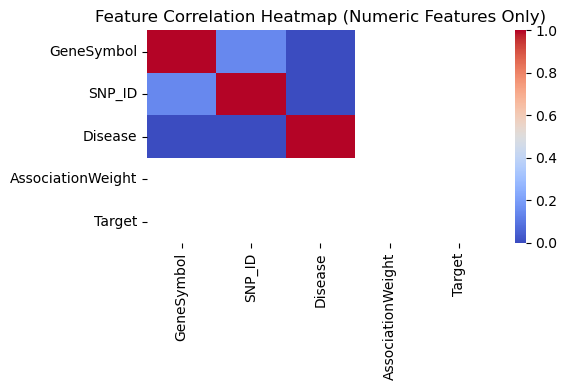


TARGET DISTRIBUTION


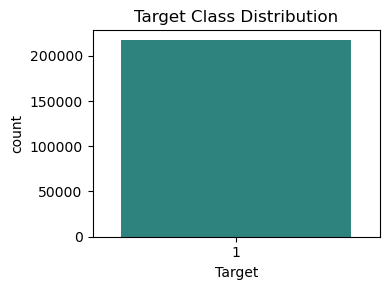


SUMMARY & SAVE CLEANED DATASET

Data types:
 GeneSymbol             int64
SNP_ID                 int64
Disease                int64
AssociationWeight    float64
Target                 int64
dtype: object
Final shape: (217324, 5)

Missing values per column:
 GeneSymbol           0
SNP_ID               0
Disease              0
AssociationWeight    0
Target               0
dtype: int64

✅ Cleaned dataset saved as 'cleaned_snp_dataset_v2.csv'
Preprocessing completed successfully!


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

# ============================================================
# INITIAL DATA LOADING
# ============================================================
print("="*60)
print("INITIAL DATA LOADING")
print("="*60)

# Load dataset (use correct filename)
df = pd.read_csv("cleaned_snp_dataset.csv")
print(f"Loaded dataset with shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

# ============================================================
# DATA CLEANING
# ============================================================
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Drop duplicates & fill missing values
df.drop_duplicates(inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)

# Encode non-numeric columns (safe conversion)
encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = encoder.fit_transform(df[col].astype(str))

print("✅ Encoded categorical columns successfully.")

# ============================================================
# OUTLIER REMOVAL
# ============================================================
print("\n" + "="*60)
print("OUTLIER REMOVAL")
print("="*60)

# Apply z-score method to numeric features only
numeric_df = df.select_dtypes(include=np.number)
z_scores = np.abs(stats.zscore(numeric_df))
df = df[(z_scores < 3).all(axis=1)]
print("✅ Shape after outlier removal:", df.shape)

# ============================================================
# CORRELATION ANALYSIS
# ============================================================
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Compute correlation on numeric columns only
corr = df.corr(numeric_only=True)

# Compact correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()

# ============================================================
# TARGET DISTRIBUTION
# ============================================================
print("\n" + "="*60)
print("TARGET DISTRIBUTION")
print("="*60)

plt.figure(figsize=(4, 3))
sns.countplot(x=df.iloc[:, -1], palette="viridis")
plt.title("Target Class Distribution")
plt.tight_layout()
plt.show()

# ============================================================
# FEATURE SUMMARY AND SAVE
# ============================================================
print("\n" + "="*60)
print("SUMMARY & SAVE CLEANED DATASET")
print("="*60)

print("\nData types:\n", df.dtypes)
print("Final shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())

df.to_csv("cleaned_snp_dataset_v2.csv", index=False)
print("\n✅ Cleaned dataset saved as 'cleaned_snp_dataset_v2.csv'")
print("Preprocessing completed successfully!")


### ✅ Statistical Summary

In [6]:

desc = df.describe().T
display(desc)

# Save cleaned dataset for next stage
df.to_csv("cleaned_snp_dataset.csv", index=False)
print("✅ Cleaned dataset saved successfully!")


,count,mean,std,min,25%,50%,75%,max
GeneSymbol,217324.0,5777.107807,3380.932214,0.0,2838.0,5807.0,8687.0,11805.0
SNP_ID,217324.0,5905.387739,3391.759186,0.0,2993.0,5910.0,8816.0,11803.0
Disease,217324.0,288.517863,173.646655,1.0,168.0,288.0,447.0,585.0
AssociationWeight,217324.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Target,217324.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


✅ Cleaned dataset saved successfully!
